In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import random
import seaborn as sns
import math
from scipy.optimize import differential_evolution
random.seed(1234567)

### Import data

In [2]:
url='https://drive.google.com/file/d/1ElDQ-Kh0wN-flOJH7m2qsG-nEK-d6TV-/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)

In [3]:
df.head()

,API,year,month,oil
0,A_30015420120000,2015,FEB,0
1,A_30015420120000,2015,MAR,5329
2,A_30015420120000,2015,APR,2996
3,A_30015420120000,2015,MAY,2369
4,A_30015420120000,2015,JUN,1957


In [4]:
#extract time series
# 2015/02>>01...
# 2015/03>>02
d = {'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}
df.month = df.month.map(d)

In [5]:
# extract time series per well
df = df.assign(timeseries = df.groupby('API')['month'].cumcount()+1)

In [6]:
df.head(5)

,API,year,month,oil,timeseries
0,A_30015420120000,2015,2,0,1
1,A_30015420120000,2015,3,5329,2
2,A_30015420120000,2015,4,2996,3
3,A_30015420120000,2015,5,2369,4
4,A_30015420120000,2015,6,1957,5


### outlier detection and data cleaning

In [7]:
# drop wells if # data points <=5
df_filtered = df.groupby('API').filter(lambda x:(x['timeseries'].count() > 5))

In [8]:
df_filtered.groupby('API').describe()

year                                                         \
                 count         mean       std     min     25%     50%     75%   
API                                                                             
A_30015420120000  37.0  2016.351351  1.005988  2015.0  2016.0  2016.0  2017.0   
A_30015420140000  17.0  2017.294118  0.469668  2017.0  2017.0  2017.0  2018.0   
A_30015420220000  33.0  2016.545455  0.904534  2015.0  2016.0  2017.0  2017.0   
A_30015420300000  32.0  2016.593750  0.874712  2015.0  2016.0  2017.0  2017.0   
A_30015420320000  35.0  2016.457143  0.950011  2015.0  2016.0  2016.0  2017.0   
...                ...          ...       ...     ...     ...     ...     ...   
A_30015424860000  28.0  2016.785714  0.738223  2016.0  2016.0  2017.0  2017.0   
A_30015424870000  28.0  2016.785714  0.738223  2016.0  2016.0  2017.0  2017.0   
A_30015424890000  40.0  2016.275000  1.012423  2015.0  2015.0  2016.0  2017.0   
A_30015424900000  34.0  2016.500000  0.929320  2015.0  2016.0  2016.5  2017.0   
A_30015424970000  41.0  2016.243902  1.019325  2015.0  2015.0  2016.0  2017.0   

                         month            ...      oil          timeseries  \
                     max count      mean  ...      75%      max      count   
API                                       ...                                
A_30015420120000  2018.0  37.0  5.891892  ...  1224.00   5329.0       37.0   
A_30015420140000  2018.0  17.0  5.470588  ...    34.00    385.0       17.0   
A_30015420220000  2018.0  33.0  6.454545  ...  2004.00  10850.0       33.0   
A_30015420300000  2018.0  32.0  6.375000  ...  5457.50  30799.0       32.0   
A_30015420320000  2018.0  35.0  6.514286  ...  4194.50  13251.0       35.0   
...                  ...   ...       ...  ...      ...      ...        ...   
A_30015424860000  2018.0  28.0  6.071429  ...  4582.00  19990.0       28.0   
A_30015424870000  2018.0  28.0  6.071429  ...  8372.00  35194.0       28.0   
A_30015424890000  2018.0  40.0  6.200000  ...  2432.75   6339.0       40.0   
A_30015424900000  2018.0  34.0  6.500000  ...  2051.25   7046.0       34.0   
A_30015424970000  2018.0  41.0  6.073171  ...  4418.00  35937.0       41.0   

                                                                  
                  mean        std  min    25%   50%    75%   max  
API                                                               
A_30015420120000  19.0  10.824355  1.0  10.00  19.0  28.00  37.0  
A_30015420140000   9.0   5.049752  1.0   5.00   9.0  13.00  17.0  
A_30015420220000  17.0   9.669540  1.0   9.00  17.0  25.00  33.0  
A_30015420300000  16.5   9.380832  1.0   8.75  16.5  24.25  32.0  
A_30015420320000  18.0  10.246951  1.0   9.50  18.0  26.50  35.0  
...                ...        ...  ...    ...   ...    ...   ...  
A_30015424860000  14.5   8.225975  1.0   7.75  14.5  21.25  28.0  
A_30015424870000  14.5   8.225975  1.0   7.75  14.5  21.25  28.0  
A_30015424890000  20.5  11.690452  1.0  10.75  20.5  30.25  40.0  
A_30015424900000  17.5   9.958246  1.0   9.25  17.5  25.75  34.0  
A_30015424970000  21.0  11.979149  1.0  11.00  21.0  31.00  41.0  

[99 rows x 32 columns]

In [9]:
#remove the outlier
newdf = df_filtered[df_filtered.groupby("API").oil.transform(lambda x : (x<x.quantile(0.75))&(x>(x.quantile(0.25)))).eq(1)]

In [10]:
newdf = newdf.drop(['year', 'month',], axis=1)
newdf.groupby('API').describe()

oil                                                     \
                 count         mean          std     min      25%     50%   
API                                                                         
A_30015420120000  17.0   848.176471   201.735977   571.0   668.00   823.0   
A_30015420140000   3.0    18.666667    12.096832     5.0    14.00    23.0   
A_30015420220000  15.0  1302.400000   301.515174   956.0  1063.50  1262.0   
A_30015420300000  16.0  3395.937500   593.132303  2652.0  2965.00  3367.5   
A_30015420320000  17.0  2104.764706   921.384049  1174.0  1235.00  1800.0   
...                ...          ...          ...     ...      ...     ...   
A_30015424860000  14.0  2797.714286   880.966727  1868.0  2138.50  2604.5   
A_30015424870000  14.0  4784.142857  1658.804521  3052.0  3557.00  3963.5   
A_30015424890000  20.0  1599.400000   468.111030  1118.0  1178.25  1465.5   
A_30015424900000  16.0  1001.500000   336.126563   713.0   757.25   925.5   
A_30015424970000  19.0  3023.263158   687.743964  2092.0  2477.00  2817.0   

                                  timeseries                             \
                      75%     max      count       mean       std   min   
API                                                                       
A_30015420120000   967.00  1197.0       17.0  24.352941  8.731704   8.0   
A_30015420140000    25.50    28.0        3.0  10.000000  7.000000   3.0   
A_30015420220000  1455.00  1983.0       15.0  21.133333  6.885457  10.0   
A_30015420300000  3674.75  4824.0       16.0  20.062500  6.647995  10.0   
A_30015420320000  2691.00  3987.0       17.0  20.000000  8.200610  10.0   
...                   ...     ...        ...        ...       ...   ...   
A_30015424860000  3251.25  4343.0       14.0  15.928571  4.953077   9.0   
A_30015424870000  6272.50  8149.0       14.0  14.714286  5.979820   1.0   
A_30015424890000  1950.00  2427.0       20.0  23.600000  7.177450  13.0   
A_30015424900000  1070.50  1935.0       16.0  20.000000  7.711463  10.0   
A_30015424970000  3631.50  4397.0       19.0  20.263158  8.204620   1.0   

                                            
                    25%   50%    75%   max  
API                                         
A_30015420120000  18.00  24.0  33.00  37.0  
A_30015420140000   6.50  10.0  13.50  17.0  
A_30015420220000  14.50  23.0  26.50  31.0  
A_30015420300000  14.75  18.5  26.25  30.0  
A_30015420320000  14.00  18.0  22.00  35.0  
...                 ...   ...    ...   ...  
A_30015424860000  12.25  15.5  18.75  26.0  
A_30015424870000  11.25  15.0  18.75  23.0  
A_30015424890000  17.75  23.0  29.25  36.0  
A_30015424900000  13.75  19.0  24.25  34.0  
A_30015424970000  16.50  21.0  25.50  32.0  

[99 rows x 16 columns]

### Model building, training

In [14]:
# choose one well for example
well = 'A_30015420220000'
t = newdf[newdf['API']==well]['timeseries']
q = newdf[newdf['API']==well]['oil']

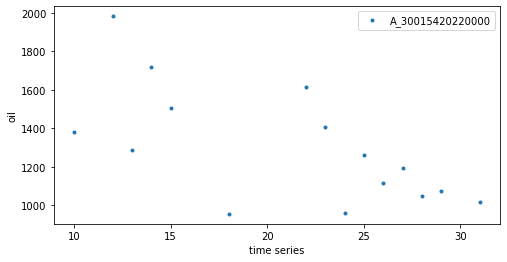

In [16]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(t, q, '.',label=well)
ax.set_xlabel('time series')
ax.set_ylabel('oil')
ax.legend()
plt.show()

In [17]:
# normalize the time and rate data
t_normalized = t.values / max(t)
q_normalized = q.values / max(q)

In [18]:
t_normalized

array([0.32258065, 0.38709677, 0.41935484, 0.4516129 , 0.48387097,
       0.58064516, 0.70967742, 0.74193548, 0.77419355, 0.80645161,
       0.83870968, 0.87096774, 0.90322581, 0.93548387, 1.        ])

In [ ]:
# function for decline curve fitting
def func(t, q0, q1, d0, d1, b, t1): 
    q1 = q0 * np.exp(d0 * t1)
    return np.where(t < t1, q0 * np.exp(d0 * t), q1 / (((1 + b * d1 * (t-t1))**(1/b))))

#params_guess=[0.1,0.1,0.1,0.1,0.1,0.1]

#result = differential_evolution(fun, [(-1,1),(-1,1),(-1,1),(-1,1),(-1,1),(-1,1)])
bounds = [(0,1), (0, 1), (0, 1), (0, 1), (0, 1),(0,1)]
result = differential_evolution(func, bounds, updating='deferred',workers=2)

### Evaluation